> ### EEE6503-01: Computer Vision

# Final Project: Domain Generalization

**<div style="text-align: right"> Due date: Dec 17th, 2024. </div>** 
**<div style="text-align: right"> Please upload your file @ learnus by 11:00 PM. </div>** 

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.** 
4. **Report your results.**   

<h2><span style="color:blue">Group 6</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-12-09 14:44:13.384636


The objective of this assignment is to address the domain generalization problem in neural networks.

In [2]:
# You may change the values below.
team_id = '000' # your team id - should be a three-digit number
root_dir = './PACS' # directory to the dataset
lr = 0.0001 # learning rate
step_size = 7 # scheduler step size (if used)

# You must not change the values below.
num_epochs = 10 # number of epochs
image_size = 64 # input image size
batch_size = 32 # batch size for training
model_name = f'{team_id}_model.pth' # model name
TEST_MODE = False # test mode -- evaluation for TAs

In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm

from collections import Counter
import random
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def set_seed(seed=42):
    # Set the seed for random number generation in Python
    random.seed(seed)
    
    # Set the seed for numpy's random number generation
    np.random.seed(seed)
    
    # Set the seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Ensure that operations are deterministic on GPU (if using CUDA)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage:
set_seed(42)

In [4]:
class PACSDataset(Dataset):
    def __init__(self, root_dir, domain, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            domain (string): Domain of interest, one of ['photo', 'art_painting', 'cartoon', 'sketch'].
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.domain = domain
        self.transform = transform

        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.images = []
        self.labels = []

        # Load images and labels
        domain_dir = os.path.join(self.root_dir, self.domain)
        for cls_name in self.classes:
            cls_dir = os.path.join(domain_dir, cls_name)
            image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.png'))]

            for img_name in image_files:
                self.images.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])

        # Calculate and print the number of images per class
        class_counts = Counter(self.labels)
        print(f"Class distribution for domain '{self.domain}':")
        for cls_name, cls_idx in self.class_to_idx.items():
            print(f"{cls_name}: {class_counts[cls_idx]} images")

        # Plot the distribution as a bar chart
        plt.bar(self.class_to_idx.keys(), [class_counts[self.class_to_idx[cls_name]] for cls_name in self.classes])
        plt.xlabel('Classes')
        plt.ylabel('Number of Images')
        plt.title(f'Class Distribution in PACS Dataset for Domain: {self.domain}')
        plt.xticks(rotation=45)
        plt.show()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Filters Initialization

In [5]:
from filters import *

Class distribution for domain 'cartoon':
dog: 389 images
elephant: 457 images
giraffe: 346 images
guitar: 135 images
horse: 324 images
house: 288 images
person: 405 images


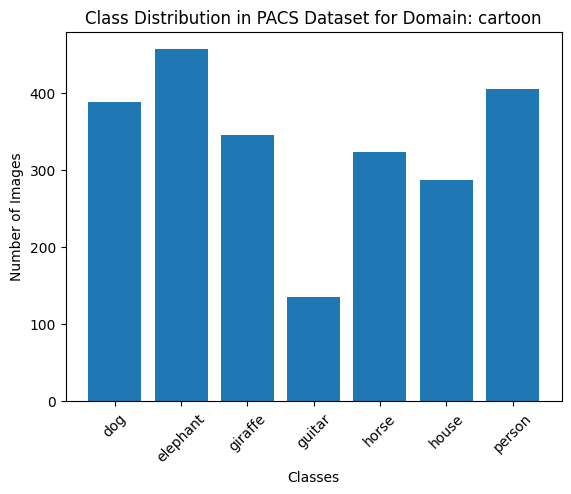

Class distribution for domain 'art_painting':
dog: 379 images
elephant: 255 images
giraffe: 285 images
guitar: 184 images
horse: 201 images
house: 295 images
person: 449 images


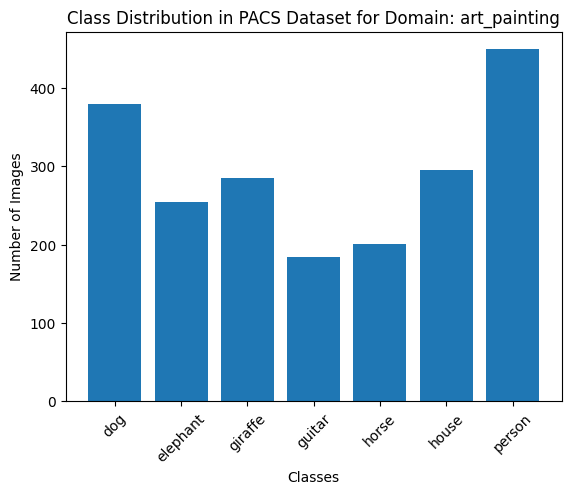

Class distribution for domain 'sketch':
dog: 772 images
elephant: 740 images
giraffe: 753 images
guitar: 608 images
horse: 816 images
house: 80 images
person: 160 images


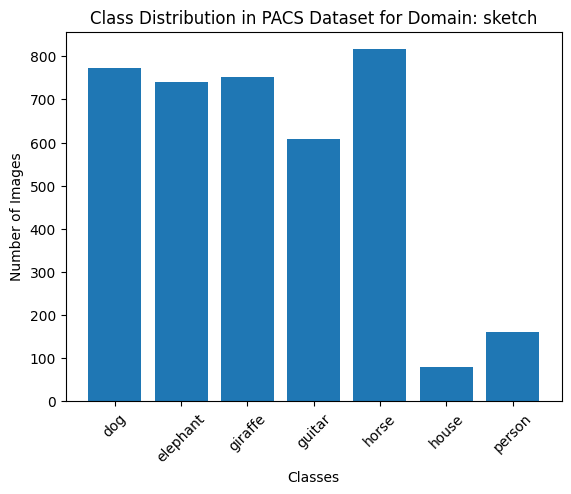

Class distribution for domain 'photo':
dog: 189 images
elephant: 202 images
giraffe: 182 images
guitar: 186 images
horse: 199 images
house: 280 images
person: 432 images


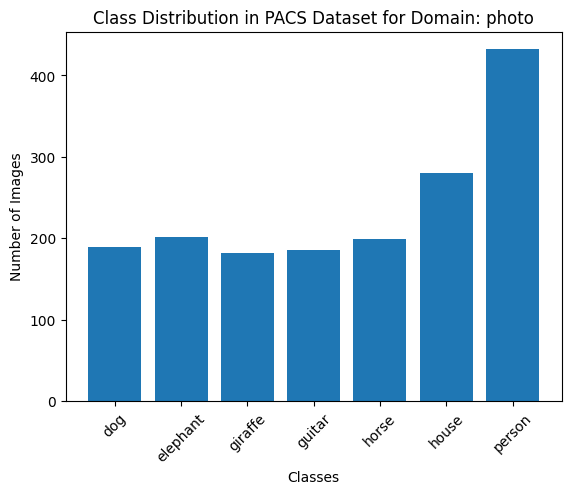

In [6]:
# Define transforms
transform_cartoon = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	# transforms.Grayscale(num_output_channels=3),
	# RandomApplyFilter(EdgePreservingFilter),
	# EdgePreservingFilter(),
	# SobelFilter(),
    RandomApplyFilter(LowPassFilter(filter_size=40)),        # Reduce flat colors and edges
    RandomApplyFilter(AddNoiseFilter()),                   # Add photo-like noise for the background
    RandomApplyFilter(AdaptiveEdgePreservingFilter()),      # Add gradients and soften edges
    RandomApplyFilter(GaussianBlurFilter()),                # Add photo-like softness
    RandomApplyFilter(HistogramEqualizationFilter()),       # Improve brightness and contrast
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
	])

transform_art = transforms.Compose([
	transforms.Resize((image_size, image_size)),
 	# transforms.Grayscale(num_output_channels=3),
	# RandomApplyFilter(EdgePreservingFilter),
	# EdgePreservingFilter(),
	# SobelFilter(),
    RandomApplyFilter(LowPassFilter(filter_size=30)),  # Smooth artistic textures
    RandomApplyFilter(EdgePreservingFilter()),        # Retain edges
    RandomApplyFilter(SharpenFilter()),               # Enhance fine details
    RandomApplyFilter(HistogramEqualizationFilter()),  # Improve contrast and lighting
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
	])

transform_sketch = transforms.Compose([
	transforms.Resize((image_size, image_size)),
 	# transforms.Grayscale(num_output_channels=3),
	# RandomApplyFilter(EdgePreservingFilter),
	# EdgePreservingFilter(),
	# SobelFilter(),
    RandomApplyFilter(SobelFilter()),                      # Enhance edges
    RandomApplyFilter(AddNoiseFilter()),                   # Add photo-like noise as the background is just white
    RandomApplyFilter(AdaptiveEdgePreservingFilter()),     # Blend lines into realistic shading
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
	])


transform_test = transforms.Compose([
	transforms.Resize((image_size, image_size)),
  	# transforms.Grayscale(num_output_channels=3),
   	# EdgePreservingFilter(),
	# SobelFilter(),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])

transform_visualize = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])


# Create datasets
dataset_train = ConcatDataset([
	PACSDataset(root_dir, 'cartoon', transform=transform_cartoon),
	PACSDataset(root_dir, 'art_painting', transform=transform_art),
	PACSDataset(root_dir, 'sketch', transform=transform_sketch),
	])

dataset_test = PACSDataset(root_dir, 'photo', transform=transform_test)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,drop_last=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [7]:
def visualize_example_images(root_dir, domain, filter_cls=None):
    """
    Visualizes example images from each class in the dataset, optionally applying a filter.

    Args:
        root_dir: The root directory of the dataset.
        domain: The domain to visualize ('art_painting', 'sketch', 'cartoon').
        filter_cls: Optional filter class to apply to the images (e.g., SobelFilter, LowPassFilter).
    """
    assert domain in ['art_painting', 'sketch', 'cartoon','photo'], "Invalid domain specified."

    def denormalize(tensor):
        """Denormalize the image tensor for visualization."""
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        return tensor * std + mean

    # Create dataset
    dataset = PACSDataset(root_dir=root_dir, domain=domain, transform=transform_visualize)

    # Initialize the filter if provided
    filter_instance = filter_cls() if filter_cls else None

    # Create a figure with subplots for each class
    fig, axs = plt.subplots(1, 7, figsize=(15, 3))
    fig.suptitle('Sample Images from Each Category')

    # For each class
    for i, class_name in enumerate(dataset.classes):
        # Find the first image of this class
        for idx in range(len(dataset)):
            if dataset.labels[idx] == i:
                image, _ = dataset[idx]

                # Denormalize the image
                image = denormalize(image)

                # Convert to numpy for further processing
                image_np = image.numpy().transpose(1, 2, 0)

                # Apply the filter if specified
                if filter_instance:
                    # Convert to PIL Image for filtering
                    pil_image = Image.fromarray((image_np * 255).astype(np.uint8))
                    pil_image = filter_instance(pil_image)
                    # Convert back to NumPy
                    image_np = np.array(pil_image) / 255.0

                # Clip values to [0, 1] range
                image_np = np.clip(image_np, 0, 1)

                # Plot the image
                axs[i].imshow(image_np)
                axs[i].set_title(class_name)
                axs[i].axis('off')
                break

    plt.tight_layout()
    plt.show()

Class distribution for domain 'art_painting':
dog: 379 images
elephant: 255 images
giraffe: 285 images
guitar: 184 images
horse: 201 images
house: 295 images
person: 449 images


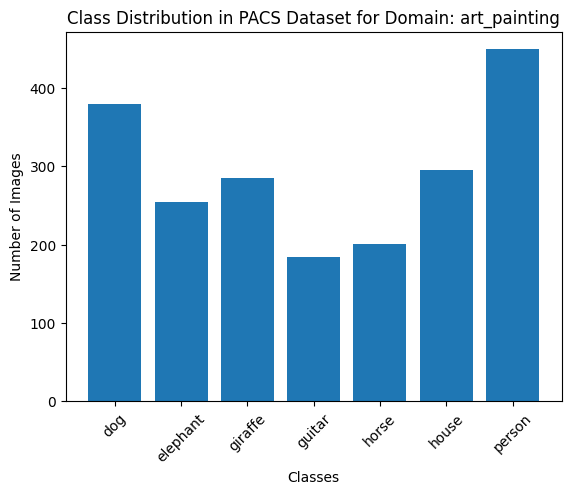

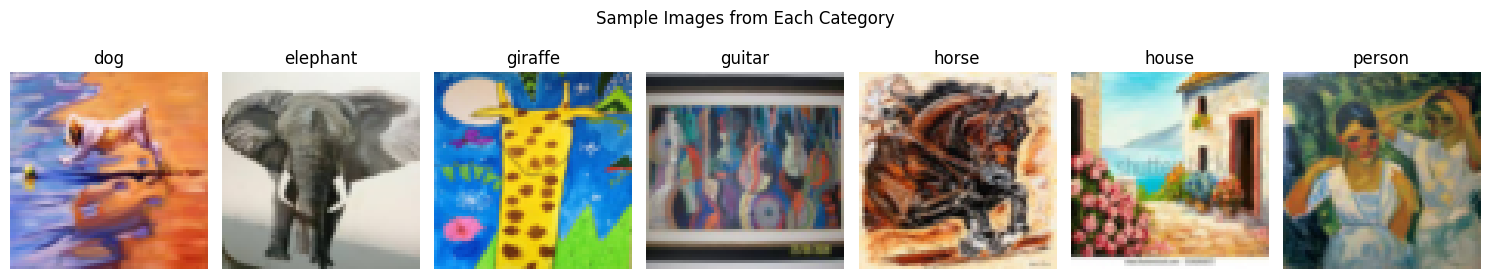

In [8]:
# visualize_example_images(root_dir, 'art_painting',EdgePreservingFilter)
visualize_example_images(root_dir, 'art_painting')
# visualize_example_images(root_dir, 'art_painting',SobelFilter)

Class distribution for domain 'cartoon':
dog: 389 images
elephant: 457 images
giraffe: 346 images
guitar: 135 images
horse: 324 images
house: 288 images
person: 405 images


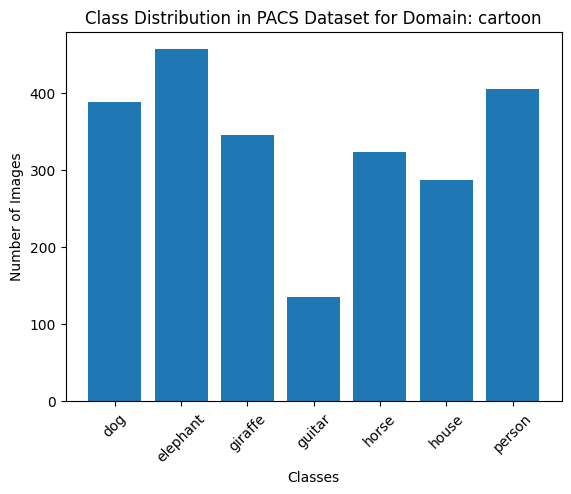

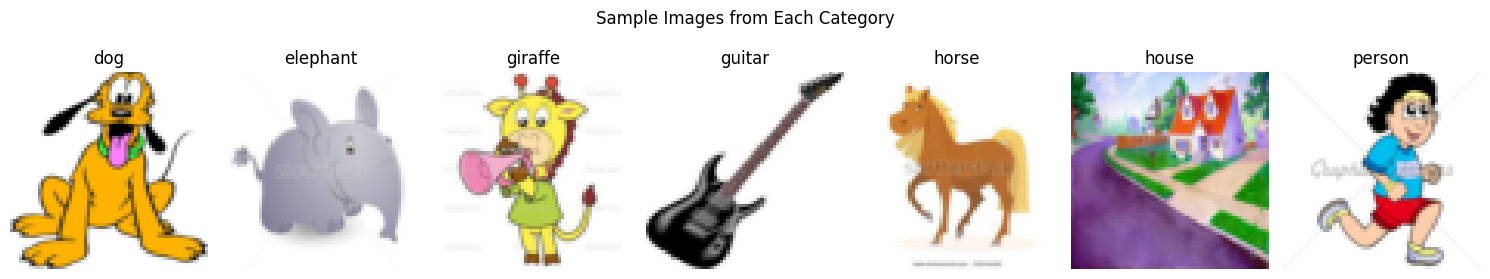

In [9]:
# visualize_example_images(root_dir, 'cartoon',SobelFilter)
visualize_example_images(root_dir, 'cartoon')

Class distribution for domain 'sketch':
dog: 772 images
elephant: 740 images
giraffe: 753 images
guitar: 608 images
horse: 816 images
house: 80 images
person: 160 images


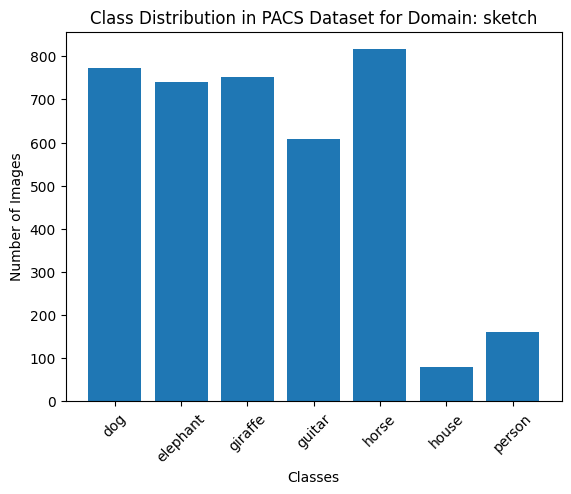

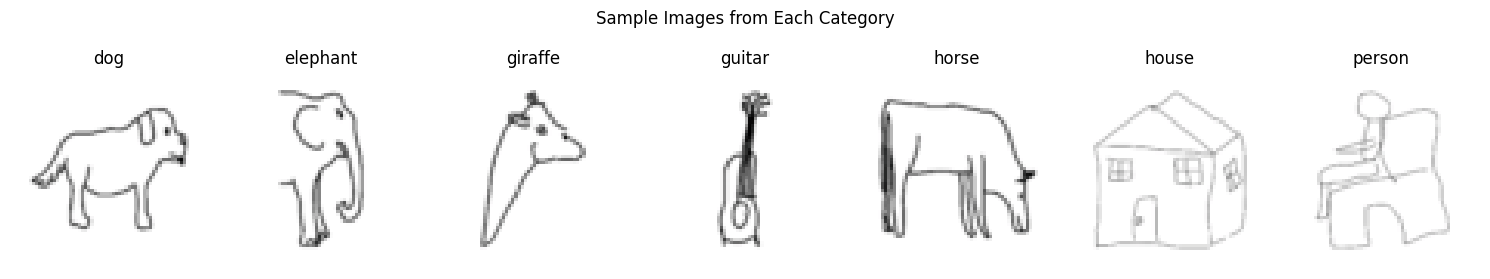

In [10]:
visualize_example_images(root_dir, 'sketch')

Class distribution for domain 'photo':
dog: 189 images
elephant: 202 images
giraffe: 182 images
guitar: 186 images
horse: 199 images
house: 280 images
person: 432 images


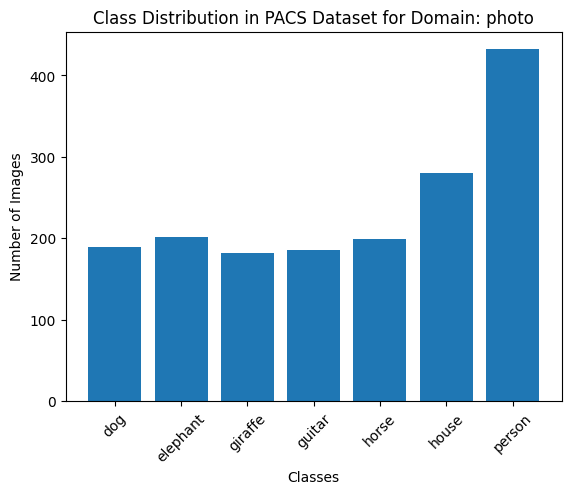

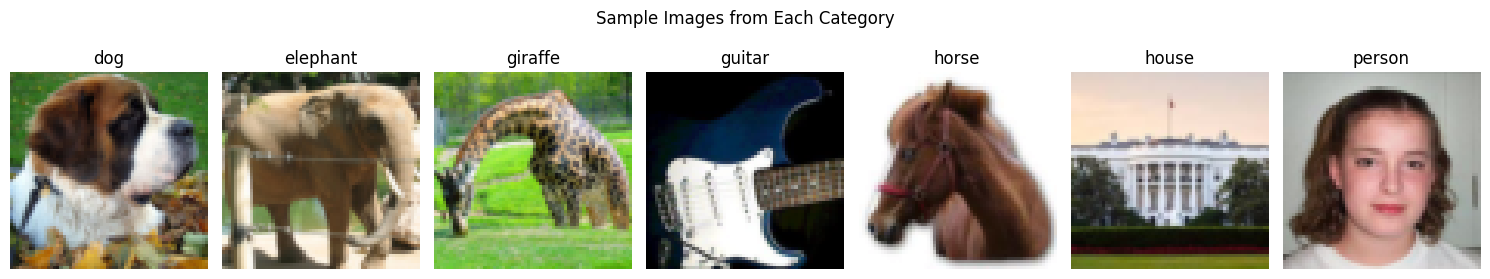

In [11]:
visualize_example_images(root_dir, 'photo')

In [12]:
from ResNet_BN import CustomModel
from DeiT import CustomDeiTModel,Base_DeiTModel
from Swin import CustomSwinModel, BaseSwinModel
from ResNet_modified import CustomResNetModel

# # Load ResNet50 model pre-trained on ImageNet
# model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# # Modify the last fully connected layer for 7 classes (PACS has 7 classes)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 7)


# Load ResNet50 model pre-trained on ImageNet
model = CustomModel()
# model = Base_DeiTModel()
# model = BaseSwinModel() # Saturated at 98.3 % in epoch 3
# model = CustomSwinModel()
# model = CustomResNetModel()

In [13]:
from custom_loss import FocalLoss
# Instantiate loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=4e-4, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# # Loss with Label Smoothing
# criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
# # criterion = FocalLoss()
# # Optimizer with weight decay
# optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

# # Scheduler for Cosine Annealing without restarts as the epoch is max to 10
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


Epoch 1/10: 100%|██████████| 260/260 [00:34<00:00,  7.58it/s]


Epoch [1/10], Loss: 1.4799, Test Accuracy: 78.98%, Learning Rate: 0.000400


Epoch 2/10: 100%|██████████| 260/260 [00:38<00:00,  6.71it/s]


Epoch [2/10], Loss: 1.0276, Test Accuracy: 88.44%, Learning Rate: 0.000400


Epoch 3/10: 100%|██████████| 260/260 [00:38<00:00,  6.68it/s]


Epoch [3/10], Loss: 0.8398, Test Accuracy: 92.34%, Learning Rate: 0.000200


Epoch 4/10: 100%|██████████| 260/260 [00:38<00:00,  6.74it/s]


Epoch [4/10], Loss: 0.7366, Test Accuracy: 93.05%, Learning Rate: 0.000200


Epoch 5/10: 100%|██████████| 260/260 [00:38<00:00,  6.71it/s]


Epoch [5/10], Loss: 0.6989, Test Accuracy: 93.29%, Learning Rate: 0.000200


Epoch 6/10: 100%|██████████| 260/260 [00:38<00:00,  6.68it/s]


Epoch [6/10], Loss: 0.6482, Test Accuracy: 94.13%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 260/260 [00:38<00:00,  6.69it/s]


Epoch [7/10], Loss: 0.6275, Test Accuracy: 93.65%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 260/260 [00:38<00:00,  6.68it/s]


Epoch [8/10], Loss: 0.6077, Test Accuracy: 93.53%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 260/260 [00:38<00:00,  6.69it/s]


Epoch [9/10], Loss: 0.5968, Test Accuracy: 93.77%, Learning Rate: 0.000050


Epoch 10/10: 100%|██████████| 260/260 [00:28<00:00,  9.25it/s]


Epoch [10/10], Loss: 0.5847, Test Accuracy: 94.37%, Learning Rate: 0.000050
Finished Training


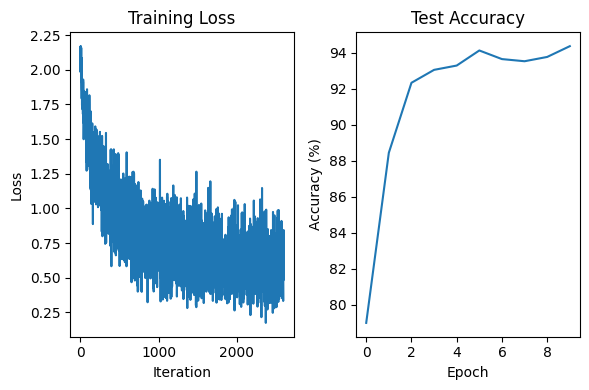

In [14]:
if not TEST_MODE:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	model = model.to(device)

	# Lists to store loss and accuracy values
	train_losses = []
	test_accuracies = []

	for epoch in range(num_epochs):
		model.train()
		running_loss = 0.0
		correct = 0
		total = 0

		for i, (inputs, labels) in enumerate(tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}')):
			inputs, labels = inputs.to(device), labels.to(device)

			optimizer.zero_grad()

			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			# Store loss at every iteration
			train_losses.append(loss.item())
			
		scheduler.step()

		# Validation
		model.eval()
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in loader_test:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

		test_accuracy = 100 * correct / total
		test_accuracies.append(test_accuracy)
	
		current_lr = optimizer.param_groups[0]['lr']
		print(f'Epoch [{epoch+1}/{num_epochs}], '
					f'Loss: {running_loss/len(loader_train):.4f}, '
					f'Test Accuracy: {test_accuracy:.2f}%, '
					f'Learning Rate: {current_lr:.6f}')

	print('Finished Training')

	# Save the model - make sure you include this file in your submission
	torch.save(model.state_dict(), f'./{model_name}')

	# Plotting after training is finished
	plt.figure(figsize=(6, 4))

	# Plot training loss
	plt.subplot(1, 2, 1)
	plt.plot(train_losses)
	plt.title('Training Loss')
	plt.xlabel('Iteration')
	plt.ylabel('Loss')

	# Plot test accuracy
	plt.subplot(1, 2, 2)
	plt.plot(test_accuracies)
	plt.title('Test Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')

	plt.tight_layout()
	plt.show()

Class-wise Accuracy Comparison

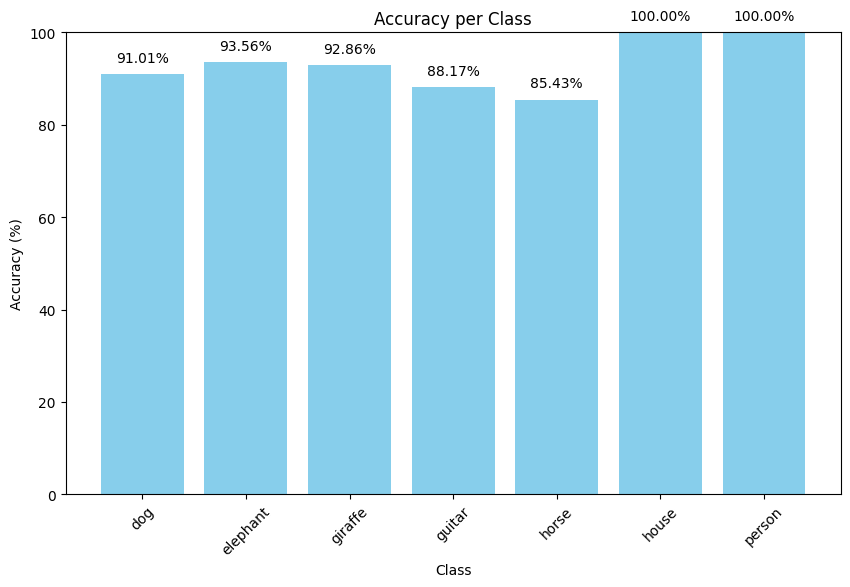

In [15]:
from collections import defaultdict

# Define class names and prepare data structures for storing results
class_names = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
results_by_class = {class_name: [] for class_name in class_names}
class_correct = defaultdict(int)
class_total = defaultdict(int)

# Function to denormalize image for proper visualization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

# Set the model to evaluation mode and run through the test set
model.eval()
with torch.no_grad():
    for inputs, labels in loader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # Store results and track accuracy for each class
        for img, true_label, pred_label in zip(inputs, labels, predicted):
            true_class = class_names[true_label.item()]
            pred_class = class_names[pred_label.item()]

            # Save image and labels in the dictionary
            results_by_class[true_class].append((img.cpu(), true_class, pred_class))

            # Update accuracy counts
            class_total[true_class] += 1
            if true_label == pred_label:
                class_correct[true_class] += 1

# Calculate accuracy for each class
class_accuracies = {class_name: 100 * class_correct[class_name] / class_total[class_name] 
                    for class_name in class_names}

# Plot the accuracy for each class with percentage labels
plt.figure(figsize=(10, 6))
bars = plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

# Add accuracy percentage above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position: middle of the bar
        height + 2,                         # Y position: slightly above the bar
        f'{height:.2f}%',                   # Text with 2 decimal points
        ha='center', va='bottom'            # Center the text horizontally
    )

plt.show()

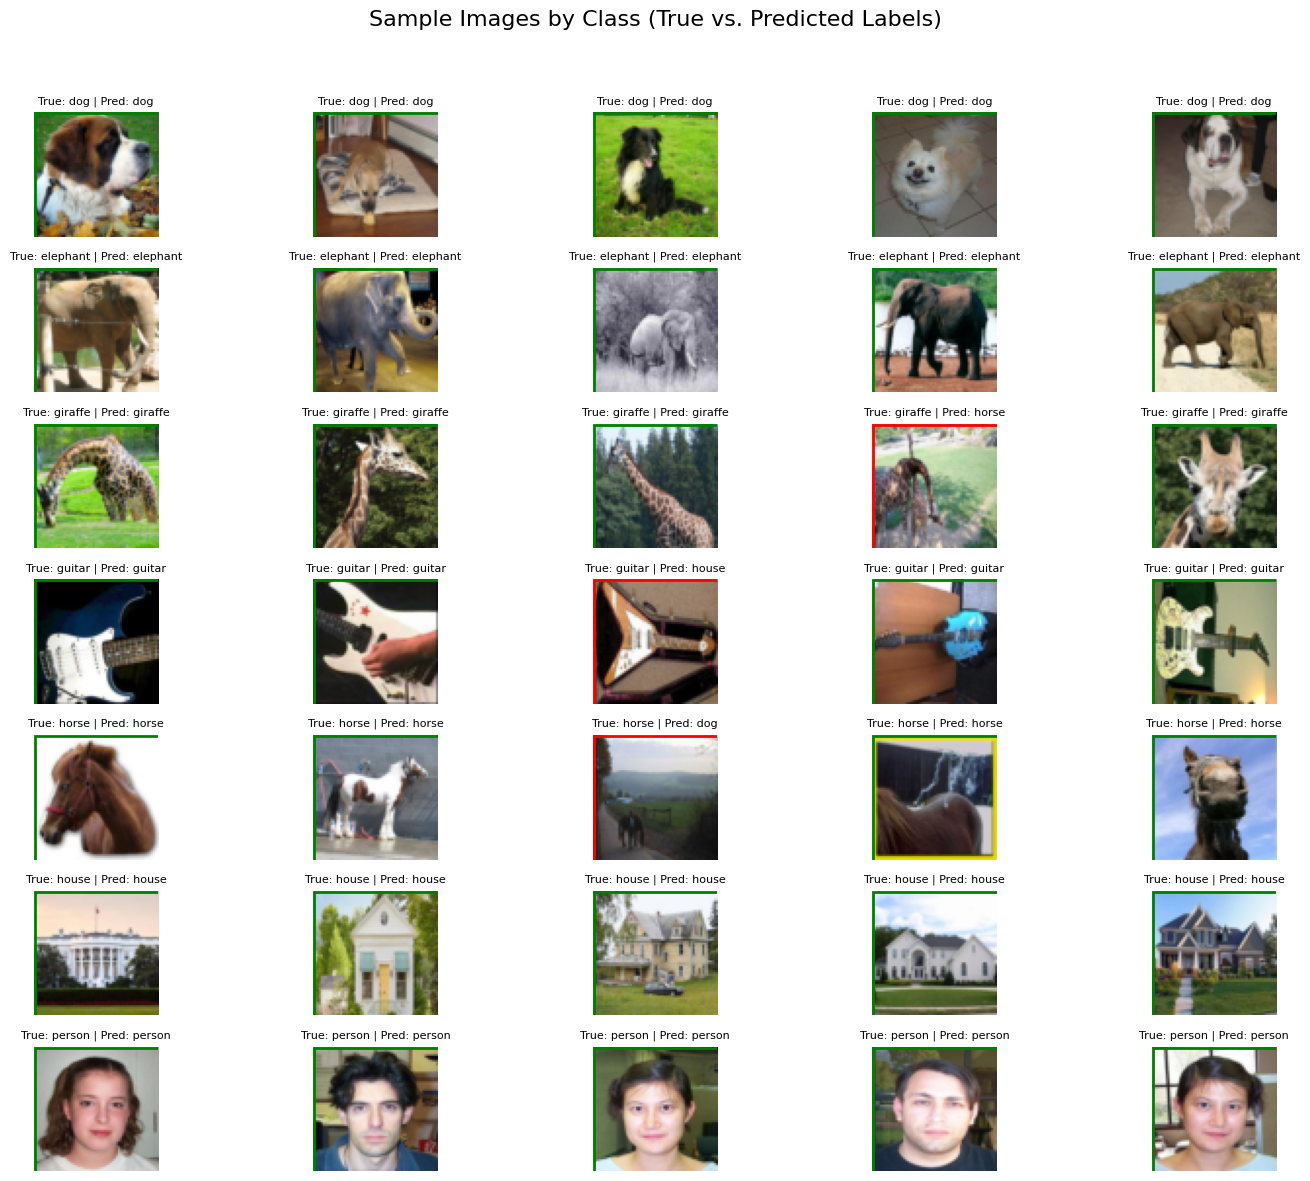

In [16]:
import matplotlib.patches as patches

# Display images with true and predicted labels by class
max_examples_per_class = 5  # Limit the number of images displayed per class
plt.figure(figsize=(15, 12))

# Iterate over each class to display images in the original order
for class_index, (class_name, results) in enumerate(results_by_class.items()):
    # Display up to 'max_examples_per_class' images per class
    for i in range(min(max_examples_per_class, len(results))):
        img, true_class, pred_class = results[i]
        
        # Denormalize the image for display
        img = denormalize(img).numpy().transpose(1, 2, 0)
        img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1] range

        # Plot the image in the grid
        ax = plt.subplot(len(results_by_class), max_examples_per_class, class_index * max_examples_per_class + i + 1)
        ax.imshow(img)
        ax.set_title(f'True: {true_class} | Pred: {pred_class}', fontsize=8)
        ax.axis('off')
        
        # Add green border if correct, red border if incorrect
        color = 'green' if true_class == pred_class else 'red'
        # Create a rectangle around the image
        rect = patches.Rectangle((0, 0), img.shape[1], img.shape[0], linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

plt.suptitle('Sample Images by Class (True vs. Predicted Labels)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [17]:
# Test code - DO NOT RUN, and DO NOT MODIFY.
# TAs will evaluate your model using their curated dataset.
if TEST_MODE:
	del model
	model = models.resnet50()
	model.load_state_dict(torch.load(f'./{model_name}'))
	
	root_dir_test = '/work/datasets/CuratedPACS'

	class CustomDataset(Dataset):
		def __init__(self, root_dir, transform=None):
			self.root_dir = root_dir
			self.transform = transform
			self.images = []
			self.labels = []
			self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
			self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
			for cls_name in self.class_to_idx.keys:
				cls_dir = os.path.join(self.root_dir, cls_name)
				for img_name in os.listdir(cls_dir):
					self.images.append(os.path.join(cls_dir, img_name))
					self.labels.append(self.class_to_idx[cls_name])
			
		def __len__(self):
			return len(self.images)

	dataset_test = CustomDataset(root_dir, transform=transform_test)

	# Peform test with the test dataset
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in loader_test:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

	print(f'Test Accuracy: {100 * correct / total:.2f}%')